# Heuristic

Эвристический подход к подсчету кол-ва книг на фото.

## Логика
**Цель:** Найти на изображении все объекты, которые похожи на прямоугольники и подходят по размеру под книгу.

**Основное предположение:** Книга — это объект, который имеет форму, близкую к прямоугольнику, и ее контур хорошо виден на изображении.

# Import

In [1]:
import os

while os.getcwd().split("/")[-1] != "book_counter":
    os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import cv2
import numpy as np
import pandas as pd
from utils.plot_images import plot_res_images_slice

# Input/Output Configuration 

In [3]:
images_folder = 'task_images'
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
image_files.sort(key=lambda x: int(x.split('.')[0]))

In [4]:
output_folder = 'heuristic_results'

os.makedirs(output_folder, exist_ok=True)

In [5]:
solution_csv_path = "solution_heuristic.csv"

# Solution

In [ ]:
def heuristic_count_books(
    image_path: str,
    min_area: int = 5000,
    max_area: int = 90000,
    max_angle_deviation: int = 20,
    output_dir: str = "heuristic_results",
) -> int:
    """Ищем формы близкие к прямоугольникам(книгам).
    Здесь нам не важен цвет, поэтому приводим к ЧБ формату

    Args:
        image_path (str): Путь до изображения
        min_area (int): Минимальная площадь контура
        max_area (int): Максимальная площадь контура, взята 90000,
            т.к. привожу все изображения к размеру 262х390, а суммарная площадь = 102 180,
            считаю, что книга будет занимать не больше 90%.
        max_angle_deviation (int): Максимальное отклонение угла от 90 градусов
        output_dir (str): Директория для сохранения изображений с разметкой

    Returns:
        int: Кол-во книг на фото
    """
    image = cv2.imread(image_path)
    # взял минимальные размеры чтобы не сильно терять в качестве
    image = cv2.resize(image, (262, 390))
    result_image = image.copy()

    # Приведение к ЧБ формату через адаптивный порог, решает проблему со сложным освещением
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # избавление от шумов
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # cv2.RETR_EXTERNAL для избавление от вложенных контуров, берем только внешние
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    book_count = 0
    for contour in contours:
        # отсеивание мелких фигур
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # аппроксимация для упрощения контура в доке opencv есть хороший пример
            perimeter = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.1 * perimeter, True)

            # проверка на четырехугольник
            if len(approx) == 4:
                # проверка, что это не просто любой четырехугольник, а близкий к прямоугольнику
                vectors = []
                for i in range(4):
                    # считаем вектор между двумя точками
                    vec = approx[(i + 1) % 4][0] - approx[i][0]
                    vectors.append(vec)

                # считаем углы между соседними векторами
                for i in range(4):
                    v1 = vectors[i]
                    v2 = vectors[(i + 1) % 4]
                    cosine = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                    angle = np.degrees(np.arccos(cosine))

                    angle_flag = True  # флаг того что углы близки к 90
                    # смотрим на отклонение угла от 90
                    deviation = abs(angle - 90)
                    if deviation > max_angle_deviation:
                        angle_flag = False

                if angle_flag:
                    book_count += 1
                    cv2.drawContours(result_image, [approx], -1, (0, 255, 0), 3)

    filename = os.path.splitext(os.path.basename(image_path))[0]
    output_path = os.path.join(output_dir, f"{filename}_result.jpg")
    cv2.imwrite(output_path, result_image)

    return book_count

In [ ]:
submission_df = pd.DataFrame(columns=['image_id', 'number_of_books'])

# Обработка всех фото
for img_file in image_files:
    img_path = os.path.join(images_folder, img_file)
    
    # применение эвристического подхода к подсчету книг
    book_count = heuristic_count_books(img_path)
    
    submission_df = pd.concat(
        [submission_df, pd.DataFrame({"image_id": [img_file.split('.')[0]], "number_of_books": [book_count]})],
        ignore_index=True,
    )

In [9]:
submission_df.to_csv(
    solution_csv_path, header=["image_id", "number_of_books"], index=False
)

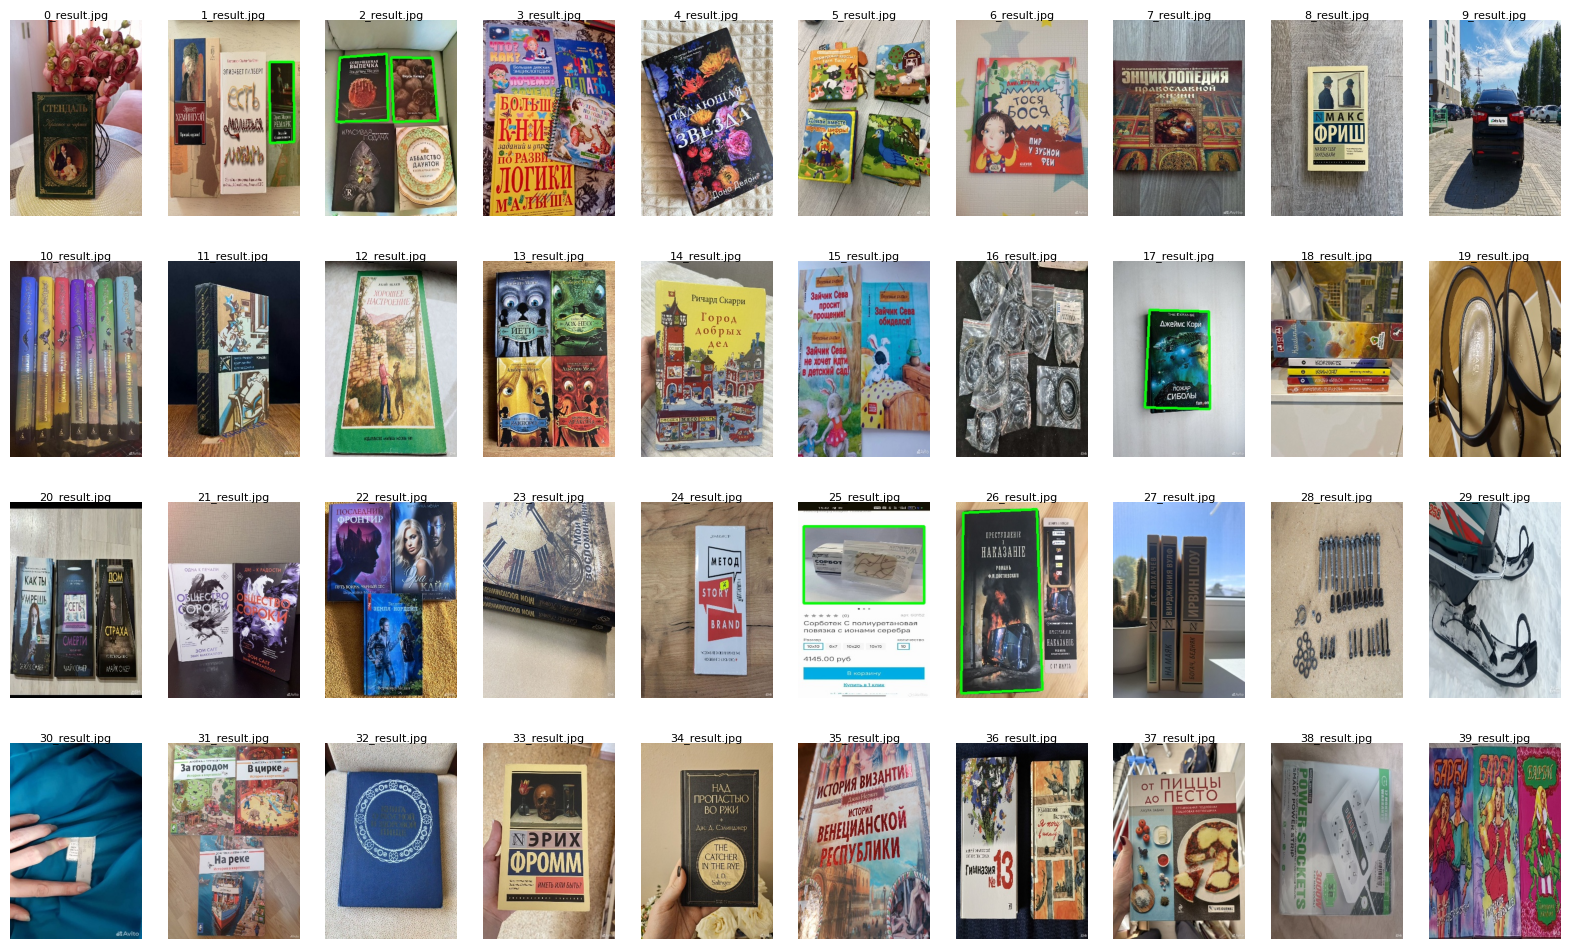

In [11]:
plot_res_images_slice(output_folder, start=0, end=40)

## Пример работы

Есть неплохие примеры работы, но они все равно не находят все книги.

![good_heuristic_ex](../imgs/good_heuristic_ex.jpg)

Даже на довольно простых фото ему не всегда удается найти книги

![bad_heuristic_ex](../imgs/bad_heuristic_ex.jpg)

## Плюсы эвристики
- Минимальные вычислительные затраты
- Не требует обучения

## Минусы эвристики
- Плохая обработка сложных случаев(перекрытия, сложный фон и т.д.)
- Низкая точность
- Необходимость тонкой настройки параметров